# Module 6: RNA-Seq Preprocessing Example Workflow

 In this notebook, we will walk through an example RNA-Seq preprocessing workflow using the HippoSeq data from the [GSE74985](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE74985) data series.
 We will use the following tools:
 - [fastqc](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/) for read quality control analysis
 - [hisat2](https://daehwankimlab.github.io/hisat2/) to create a reference index and align reads to the reference
 - [samtools](https://www.htslib.org/) to convert SAM files to BAM files, sort BAM files, and index BAM files prior to quantification
 - [stringtie](https://ccb.jhu.edu/software/stringtie/) to quantify gene expression
 - [multiqc](https://multiqc.info/) to aggregate the results of the fastqc analyses
 - [pandas](https://pandas.pydata.org/) to aggregate the results of the stringtie analyses into a single dataframe
 - [anndata](https://anndata.readthedocs.io/en/latest/) to create an AnnData object for downstream analysis

 As a reminder, this is **one** example workflow.  There are many different ways to preprocess RNA-Seq data.  This is just one example.

 The goal of this notebook is to demonstrate the use of the tools listed above.  You are encouraged to explore other tools and workflows, especially as it relates to your final project.

 First, let's make sure we have the necessary tools installed.
## Install Tools


In [ ]:
%%bash
mamba install -c bioconda hisat2 stringtie fastqc multiqc anndata


## Fetch Data
 Next, let's make a copy of the .fastq files for this study in our working directory.  We will use these files for the rest of the workflow.

 So as to avoid a long download, we have made the .fastq.gz files available on the rockfish `edulogin` server.  We will copy them from there to a new directory which we will call `data`.

 Run the following cells to get the files.

 Estimated Wall time: 5-10 minutes

In [ ]:
%%bash
mkdir data

cp /data/me440_lgoff2/datasets/RNA-Seq/data/raw/GSE74985/*.fastq.gz data/


## Fetch mouse reference genome GRCm29 (.fa) and reference annotation (.gtf)
 In order to align the reads in the .fastq.gz files, we will need to have a reference genome and associated annotation file.

 We will use the mouse reference genome GRCm39 and the associated annotation file from the [Gencode](https://www.gencodegenes.org/mouse/) project.

 The urls are provided below.  Run this cell to download the files into a new directory called `reference`.

In [ ]:
%%bash
refDir="reference"
mkdir $refDir
genomeURL="https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M33/GRCm39.primary_assembly.genome.fa.gz"
annotationURL="https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M33/gencode.vM33.annotation.gtf.gz"

wget --directory-prefix=$refDir $genomeURL
wget --directory-prefix=$refDir $annotationURL


 We will also need to unzip the files using `gunzip`

In [ ]:
%%bash
gunzip reference/*.gz


## Run `fastqc`
 As we did last week, we will run `fastqc` on the .fastq.gz files to check the quality of the reads.

 We will schedule the jobs using `sbatch` so that they run on the cluster, allowing us to run multiple jobs in parallel.

 We will put the output of `fastqc` in a new directory called `fastqc_output`.

 Estimated Wall time: 5-10 minutes

In [ ]:
%%bash
mkdir fastqc_output


In [ ]:
%%bash
for file in data/*.fastq.gz
do
	sbatch --job-name=$file-fastqc -o $file-fastqc.out -e $file-fastqc.err --wrap="fastqc -o fastqc_output $file"
done


## Build Hisat2 index
 While those jobs are running, we will start the process of building a hisat2 index for the reference genome.

 Again, we will create a new directory called `hisat2_index` to store the index files.

 Even though this is only one job, we are still going to use `sbatch` to schedule it on the cluster. So we can continue to run other jobs at the same time.

In [ ]:
%%bash
mkdir hisat2_index


In [ ]:
%%bash
jobName="hisat_index"
sbatch --job-name=$jobName -o $jobName.out -e $jobName.err --ntasks=1 --cpus-per-task=16 --mem=12G --time=4:00:00 --wrap="hisat2-build -p 16 -f reference/GRCm39.primary_assembly.genome.fa hisat2_index/GRCm39.primary_assembly.genome"


## Run Hisat2 for each sample
 The next step in our preprocessing workflow is to align the reads in the .fastq.gz files to the reference genome.

 **We _must_ wait for the `hisat2-build` job to finish before we can run the `hisat2` jobs.**

 You can check on the status of the `hisat2-build` job using `sacct`.

In [ ]:
%%bash
sacct


 Once the `hisat2-build` job is complete, we can organize and submit the `hisat2` alignment jobs.

 Here we are constructing each job with the following structure:

 ``` hisat2 -p 16 -x <path_to_hisat2_index> -U <input_fastq_file> -S <output_sam_file> ```

 The `-p 16` argument here is asking for 16 threads to be used for the alignment.

 We also have to let slurm know that we are using 16 threads by including `--cpus-per-task=16` in the `sbatch` command. (see below)

 We are also requesting 12G of memory per job with `--mem=12G`.

 The output `.sam` files will be placed in a new directory called `hisat2_alignments`.

 Estimated time: 30+ minutes or more


In [ ]:
%%bash
mkdir hisat2_alignments


In [ ]:
%%bash
for file in data/*.fastq.gz
do
    base=$(basename $file .fastq.gz)
    sbatch --job-name=$base-hisat2 -o hisat2_alignments/$base-hisat2.out -e hisat2_alignments/$base-hisat2.err --cpus-per-task=16 --mem=12G --wrap="hisat2 -p 16 -x hisat2_index/GRCm39.primary_assembly.genome -U $file -S hisat2_alignments/$base.sam"
done


## Convert SAM to BAM
 Once all of the alignment jobs have been completed successfully (again, you can check for this using sacct), we can convert the `.sam` files to the more compressed (and faster) `.bam` files using `samtools`.

 The structure of the command to do this is:

 ``` samtools view -bS <input_sam_file> > <output_bam_file> ```

 -`b` tells `samtools` to output a `.bam` file
 -`S` tells `samtools` that the input file is a `.sam` file

 The output is redirected with `>` to the specified output `.bam` file.

 We will also use `sbatch` to schedule these jobs on the cluster.

 Estimated time: 5-10 minutes

In [ ]:
%%bash
for file in hisat2_alignments/*.sam
do
    base=$(basename $file .sam)
    sbatch --job-name=$base-sam2bam -o hisat2_alignments/$base-sam2bam.out -e hisat2_alignments/$base-sam2bam.err --wrap="samtools view -bS $file > hisat2_alignments/$base.bam"
done


## Sort BAM files
 Once the .bam files are all created, we will sort them, in chromosomal position order, using `samtools sort`.

 The structure of the command to do this is:

 ``` samtools sort <input_bam_file> -o <output_sorted_bam_file> ```

 Here, the `-o` flag is used to specify the output file and you will see below we're creating a new `.sorted.bam` file.

 Estimated time: 10-15 minutes

In [ ]:
%%bash
for file in hisat2_alignments/*.bam
do
    base=$(basename $file .bam)
    sbatch --job-name=$base-sort -o hisat2_alignments/$base-sort.out -e hisat2_alignments/$base-sort.err --wrap="samtools sort $file -o hisat2_alignments/$base.sorted.bam"
done


## Clean up the SAM files
 To save some disk space, we will remove the `.sam` files as we've already converted them to `.bam` files.

 Estimated time: <30 seconds

In [ ]:
%%bash
rm hisat2_alignments/*.sam


## Index the BAM files
 The final step in the alignment process is to index the `.bam` files using `samtools index` so that they can be used for quantification.

 This step is required by most tools that take a `.bam` file as input and it helps the downstream tools to run/query the `.bam` files more efficiently.

 This command will produce, for each file `<file>.bam`, a new file `<file>.bam.bai`. This is the index file.

 Estimated time: 2-3 minutes

In [ ]:
%%bash
for file in hisat2_alignments/*.sorted.bam
do
    base=$(basename $file .sorted.bam)
    sbatch --job-name=$base-index -o hisat2_alignments/$base-index.out -e hisat2_alignments/$base-index.err --wrap="samtools index $file"
done


## Quantify gene expression with StringTie
 We will use [`stringtie`](https://ccb.jhu.edu/software/stringtie/) to quantify gene expression in each of the samples. There are many other options/tools you could use for this including `featureCounts` or `HTSeq`.

 Stringtie is a tool that primarily creates a new assembly (gene annotations) from a given sample.  However, we are going to use a curated reference annotation/assembly from the [Gencode](https://www.gencodegenes.org/mouse/) project.

 In this regard, we are only going to use stringtie in 'expression estimation mode' (`-e`) to _only_ quantify gene expression in each sample given a reference transcriptome (`-G`).

 As an added bonus, strintie will ouput not only the raw read coverage, but also the normalized expression values (TPM and FPKM) for each gene/transcript.

 The structure of the command to do this is:

 ``` stringtie -p 4 -e -G <path_to_reference_annotation> -A <output_abundance_file> <input_bam_file> ```

 -`-p 4` tells `stringtie` to use 4 threads
 -`-e` tells `stringtie` to run in expression estimation mode
 -`-G` tells `stringtie` to use the specified reference annotation file
 -`-A` tells `stringtie` to output a tab-delimited file with abundance estimates for each gene/transcript


 Estimated time: 5-10 minutes

In [ ]:
%%bash
mkdir stringtie_quant


In [ ]:
%%bash
for file in hisat2_alignments/*.sorted.bam
do
    base=$(basename $file .sorted.bam)
    sbatch --job-name=$base-stringtie -o stringtie_quant/$base-stringtie.out -e stringtie_quant/$base-stringtie.err --cpus-per-task=4 --wrap="stringtie -p 4 -e -G reference/gencode.vM33.annotation.gtf -A stringtie_quant/${base}_abundances.tab $file"
done


## Run multiqc
 Now that we've run `fastqc`, `hisat2`, and `stringtie` on all of the samples, we can aggregate the log files and reports using `multiqc`.

 Estimated time: <1 minute

In [ ]:
%%bash
mkdir reports


In [ ]:
%%bash
multiqc --outdir=reports .


# Aggregating the expression estimates
 Let's aggregate all of the `abundance.tab` files into a single pandas dataframe.

 _Note: Now we're switching over to python to use pandas and anndata to aggregate the expression estimates into a single object._


In [1]:
import pandas as pd
import glob # we'll use this 'base' python package to get a list of all abundance files (see below).  You will not need to install anything specific here.


### Make a list of all abundance files

 `glob.glob` will return a list of all files that match the specified pattern.  Here, we are looking for all files that end in `_abundances.tab` in the `stringtie_quant` directory.

In [2]:
abundance_files = glob.glob("stringtie_quant/*_abundances.tab")
abundance_files.sort() #In place sorting alphanumerically


### Parse abundance files to get sample names (in same order)

 We will use the sample names to name the columns of the expression dataframe.

 This line will split the file path for to parse out the sample names.

In [3]:
sample_names = [x.split("/")[1].split("_")[0] for x in abundance_files]

sample_names


['SRR2916027',
 'SRR2916028',
 'SRR2916029',
 'SRR2916030',
 'SRR2916031',
 'SRR2916032',
 'SRR2916033',
 'SRR2916034',
 'SRR2916035',
 'SRR2916036',
 'SRR2916037',
 'SRR2916038',
 'SRR2916039',
 'SRR2916040',
 'SRR2916041',
 'SRR2916042',
 'SRR2916043',
 'SRR2916044',
 'SRR2916045',
 'SRR2916046',
 'SRR2916047',
 'SRR2916048',
 'SRR2916049',
 'SRR2916050']

 The next cell provides a list of column names upon which to aggregate duplicate expression values.

 It will also be used to set the index of the expression dataframe for each imported abundance file.

In [4]:
#group_value = ["Gene ID","Gene Name"]
group_value = ["Gene Name"]


### Read in abundance files with `pandas.read_csv``
 Next we will use list comprehension to read in all abundance files (in order) into a list of pandas dataframes.

 Note:  This step produces a _list_ of pandas dataframes.  Each dataframe is a single sample's expression estimates.

In [7]:
abundances_list = [pd.read_csv(x, sep="\t",index_col=group_value) for x in abundance_files]

len(abundances_list)

24

### Merge the abundance dataframes into a single dataframe using the `pandas.DataFrame.join` method on the index

 We will use the first dataframe ['TPM'] column as the starting point and join the remaining dataframe ['TPM'] columns to it.

 Note: We're using the ['TPM'] column which contains the normalized 'transcripts per million' expression values. You could also use the ['FPKM'] column which contains the normalized fpkm values.

 Note: `stringtie` only returns the normalized expression estimates and does not provide the 'raw_counts' or 'length' columns.  If you need these, (ie. as would be needed for DESeq2 or edgeR) you will need to use a different tool (e.g. `featureCounts` or `HTSeq`).

In [8]:
expr = pd.DataFrame({sample_names[0]:abundances_list[0]["TPM"]}, index=abundances_list[0].index)
expr = expr.groupby(group_value).sum("TPM") # Sum TPMs for fragmented genes output as duplicate rows by StringTie

for i in range(1,len(abundances_list)):
    expr_ = abundances_list[i]["TPM"]
    expr_ = expr_.groupby(group_value).sum("TPM")
    expr = expr.join(expr_, how="outer")
    expr.rename(columns={expr.columns[-1]: sample_names[i]},inplace=True)


 Check that the columns of the expression dataframe match sample names

In [9]:
all(expr.columns == sample_names)


True

## Create a dataframe of gene information
 Grab the gene IDs from the index of the expression dataframe and populate a 'geneInfo' dataframe

In [10]:
geneInfo = pd.DataFrame(expr.index, columns=group_value)
geneInfo = geneInfo.set_index(group_value)

geneInfo

""
Gene Name
0610005C13Rik
0610006L08Rik
0610009B22Rik
0610009E02Rik
0610009L18Rik
...
n-R5s71
n-R5s86
n-R5s88


### Get the sample metadata

 We have provided the file `GSE74985_sample_info.csv` which contains the sample metadata for the samples in this study.

 Let's read this in using `pandas.read_csv` and set the index to be the `Run` column which will match the sample names in the expression dataframe `expr`.

In [12]:
metadata_file = "GSE74985_sample_info.csv"

metadata = pd.read_csv(metadata_file, index_col=["Run"])

metadata.head()

,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_type,Center Name,Consent,DATASTORE filetype,...,Location,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,tissue
Run,,,,,,,,,,,,,,,,,,,,,
SRR2916027,RNA-Seq,94,3286556216,PRJNA302123,SAMN04266726,1601660456,DG granule cell,GEO,public,"fastq,sra,run.zq",...,DG,Mus musculus,ILLUMINA,2016-04-22T00:00:00Z,2015-11-25T09:53:00Z,1,GSM1939675,Ventral DG granule cells,SRP066161,hippocampus
SRR2916028,RNA-Seq,94,3757259900,PRJNA302123,SAMN04266727,1832948568,DG granule cell,GEO,public,"run.zq,fastq,sra",...,DG,Mus musculus,ILLUMINA,2016-04-22T00:00:00Z,2015-11-25T09:49:00Z,1,GSM1939676,Ventral DG granule cells,SRP066161,hippocampus
SRR2916029,RNA-Seq,94,3253505534,PRJNA302123,SAMN04266728,1589194956,DG granule cell,GEO,public,"run.zq,sra,fastq",...,DG,Mus musculus,ILLUMINA,2016-04-22T00:00:00Z,2015-11-25T10:06:00Z,1,GSM1939677,Ventral DG granule cells,SRP066161,hippocampus
SRR2916030,RNA-Seq,100,2016456400,PRJNA302123,SAMN04266729,939134131,DG granule cell,GEO,public,"sra,fastq,run.zq",...,DG,Mus musculus,ILLUMINA,2016-04-22T00:00:00Z,2015-11-25T09:46:00Z,1,GSM1939678,Dorsal DG granule cells,SRP066161,hippocampus
SRR2916031,RNA-Seq,100,1926723700,PRJNA302123,SAMN04266732,898284223,DG granule cell,GEO,public,"fastq,run.zq,sra",...,DG,Mus musculus,ILLUMINA,2016-04-22T00:00:00Z,2015-11-25T09:47:00Z,1,GSM1939679,Dorsal DG granule cells,SRP066161,hippocampus


### Trim metadata to only those columns of interest
 We will only be using a subset of the columns in the metadata file.  Let's trim the metadata dataframe to only those columns of interest.


In [13]:
metadata = metadata[["cell_type","Location","Organism","Sample Name","source_name","tissue"]]

metadata.head()

,cell_type,Location,Organism,Sample Name,source_name,tissue
Run,,,,,,
SRR2916027,DG granule cell,DG,Mus musculus,GSM1939675,Ventral DG granule cells,hippocampus
SRR2916028,DG granule cell,DG,Mus musculus,GSM1939676,Ventral DG granule cells,hippocampus
SRR2916029,DG granule cell,DG,Mus musculus,GSM1939677,Ventral DG granule cells,hippocampus
SRR2916030,DG granule cell,DG,Mus musculus,GSM1939678,Dorsal DG granule cells,hippocampus
SRR2916031,DG granule cell,DG,Mus musculus,GSM1939679,Dorsal DG granule cells,hippocampus


 We would also like to independently use the values found in the `source_name` column (e.g. ['DG','CA1','CA2'] and ['dorsal','ventral'], etc)

 To do this, we will split that column on the space character and create new columns for `position`, `Location`, and `cell` in the metadata dataframe.

In [14]:
metadata[["position","Location","cell"]] = metadata["source_name"].str.split(" ",2,expand=True)

metadata.head()

/tmp/ipykernel_288977/2921622186.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  metadata[["position","Location","cell"]] = metadata["source_name"].str.split(" ",2,expand=True)


,cell_type,Location,Organism,Sample Name,source_name,tissue,position,cell
Run,,,,,,,,
SRR2916027,DG granule cell,DG,Mus musculus,GSM1939675,Ventral DG granule cells,hippocampus,Ventral,granule cells
SRR2916028,DG granule cell,DG,Mus musculus,GSM1939676,Ventral DG granule cells,hippocampus,Ventral,granule cells
SRR2916029,DG granule cell,DG,Mus musculus,GSM1939677,Ventral DG granule cells,hippocampus,Ventral,granule cells
SRR2916030,DG granule cell,DG,Mus musculus,GSM1939678,Dorsal DG granule cells,hippocampus,Dorsal,granule cells
SRR2916031,DG granule cell,DG,Mus musculus,GSM1939679,Dorsal DG granule cells,hippocampus,Dorsal,granule cells


## Create AnnData object
Finally, we will use the `anndata` package to create an AnnData object from the expression dataframe (`expr`), the gene information dataframe (`geneInfo`) and the metadata dataframe (`metadata`).

Before we can do that, we will need to import the `anndata` package


In [15]:
import anndata as ad


### Create AnnData object

Note: Since the `expr` dataframe is currently `genes X samples`, we will need to transpose it to be `samples X genes` before creating the AnnData object.

We will also set the `obs` and `var` attributes of the AnnData object to be the `metadata` and `geneInfo` dataframes, respectively.


In [16]:
adata = ad.AnnData(X=expr.T, obs=metadata, var=geneInfo)


## Cleaning up the AnnData object
 Now that we have an `AnnData` object, we can do some additional cleaning up.

 Let's start by removing genes with no expression in any sample

In [17]:
adata = adata[:,adata.X.sum(axis=0)>0]

## Visualizing gene expression with a custom plotting function

 We now have an object that contains all of our normalized expression estimates, the gene names, and sample information in `adata`

 If we want to visualize the expression of a particular gene, we can use the following function to plot the expression of that gene across all samples.

In [18]:
import plotnine as pn

def plot_gene(adata ,gene_id):                       
    dat_ = adata[:,gene_id].copy()
    plot_df = dat_.obs.copy()
    plot_df["TPM"] = dat_.X.flatten()
    p =  (                                                      
        pn.ggplot(                                              
            plot_df,     
            pn.aes(x="source_name", y="TPM", fill="Location"),        
        )
        + pn.geom_boxplot(outlier_alpha=0.0)
        + pn.geom_point(size = 1)                               
        + pn.ggtitle(gene_id)                                   
        + pn.xlab("Sample")                          
        + pn.ylab("Gene Expression (TPM)")        
        + pn.labs(color="Location") 
        + pn.theme(legend_position="bottom")
        + pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1))
        + pn.theme(figure_size=(5, 6))
    )
    return p  


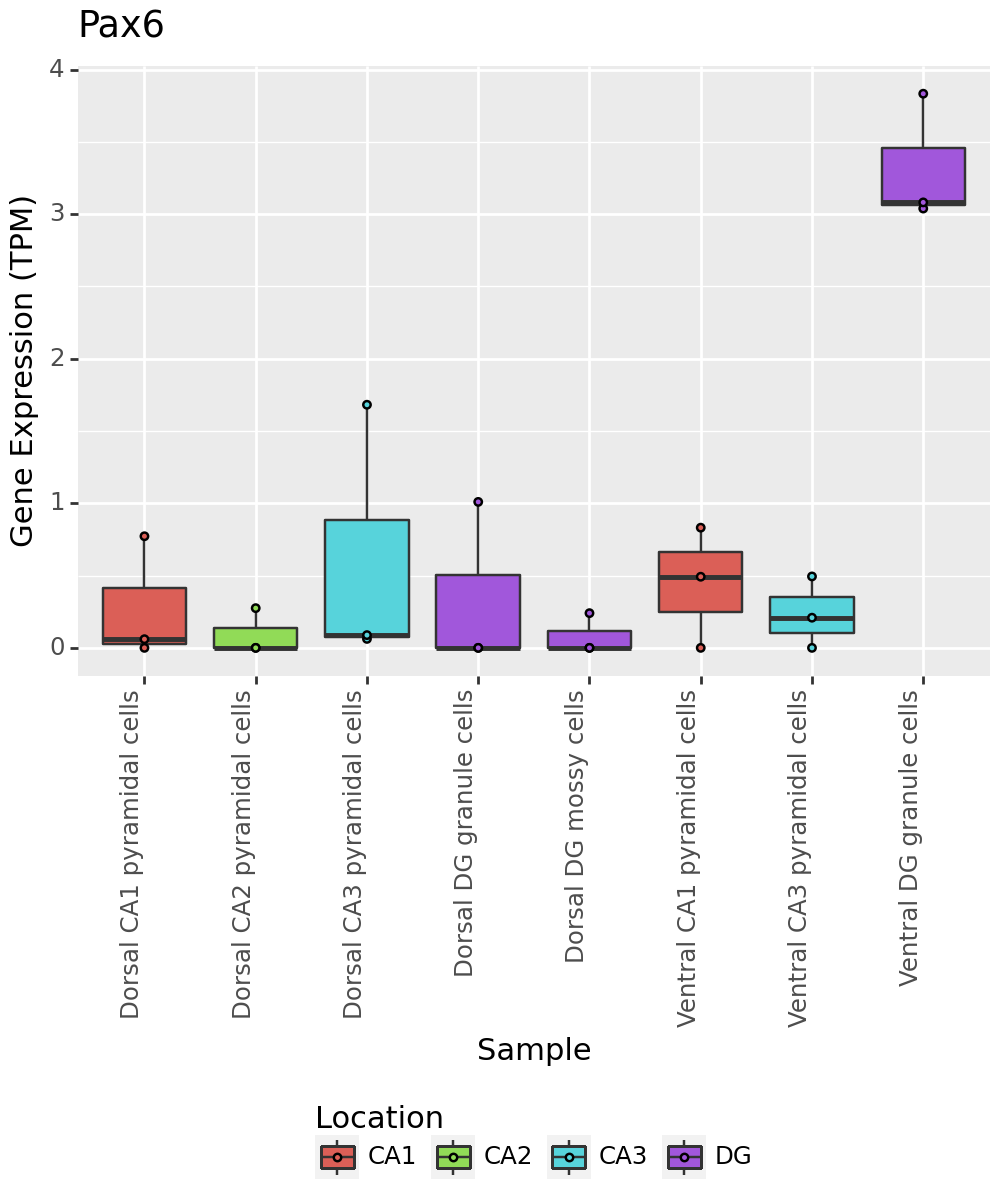

<Figure Size: (500 x 600)>

In [19]:
plot_gene(adata,"Pax6")


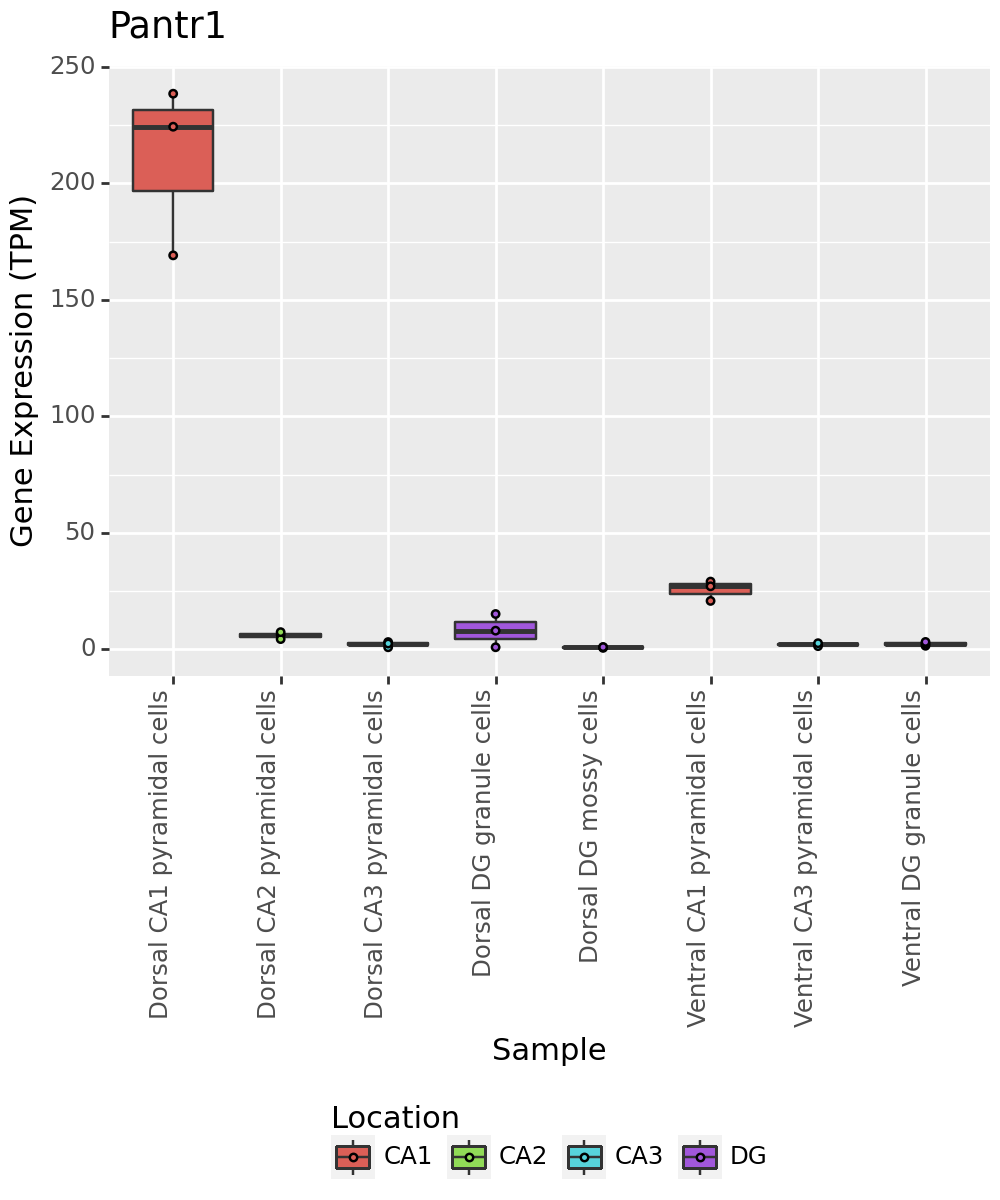

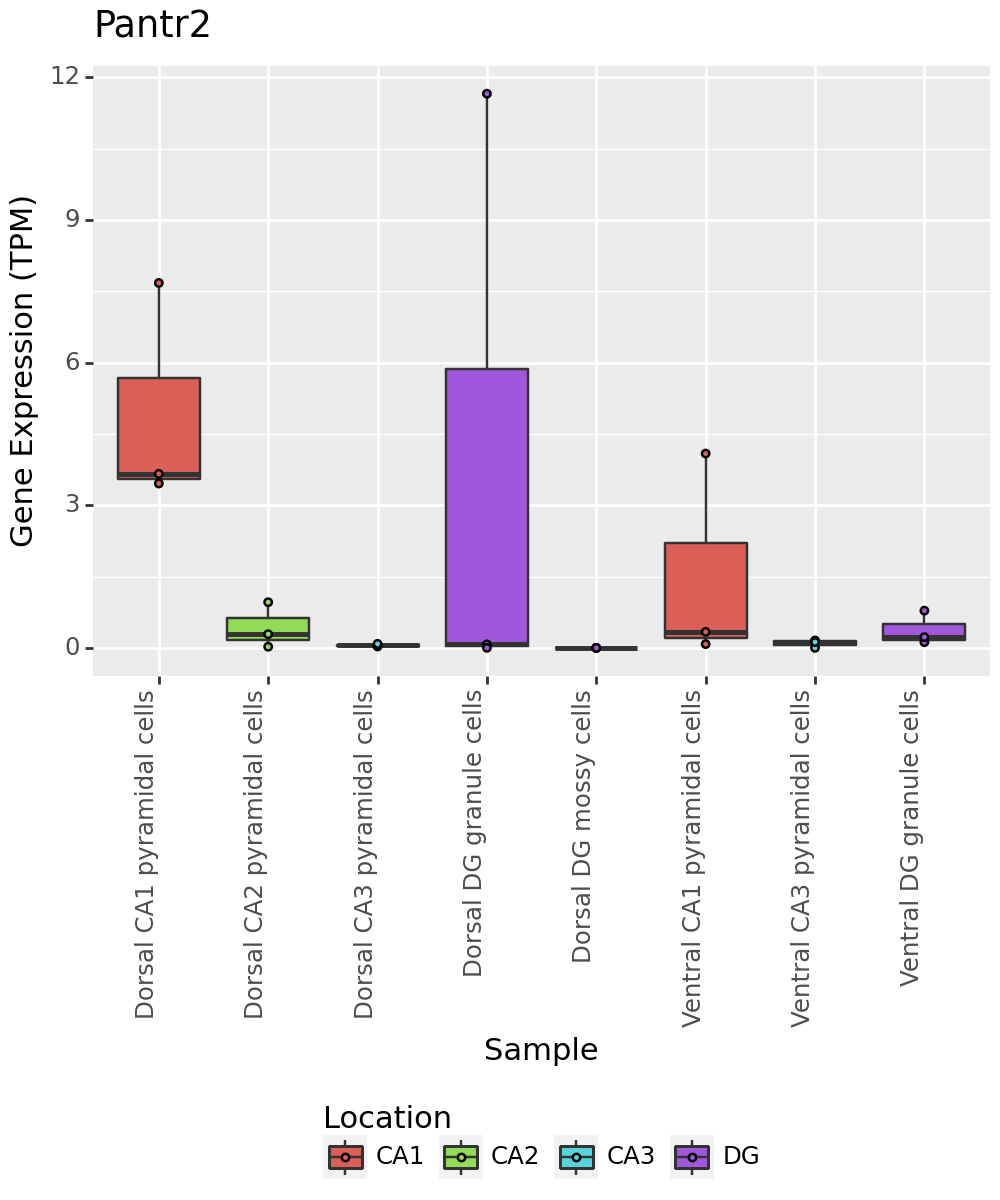

[<Figure Size: (500 x 600)>, <Figure Size: (500 x 600)>]

In [20]:
genes = ["Pantr1","Pantr2"]
[plot_gene(adata,x) for x in genes]


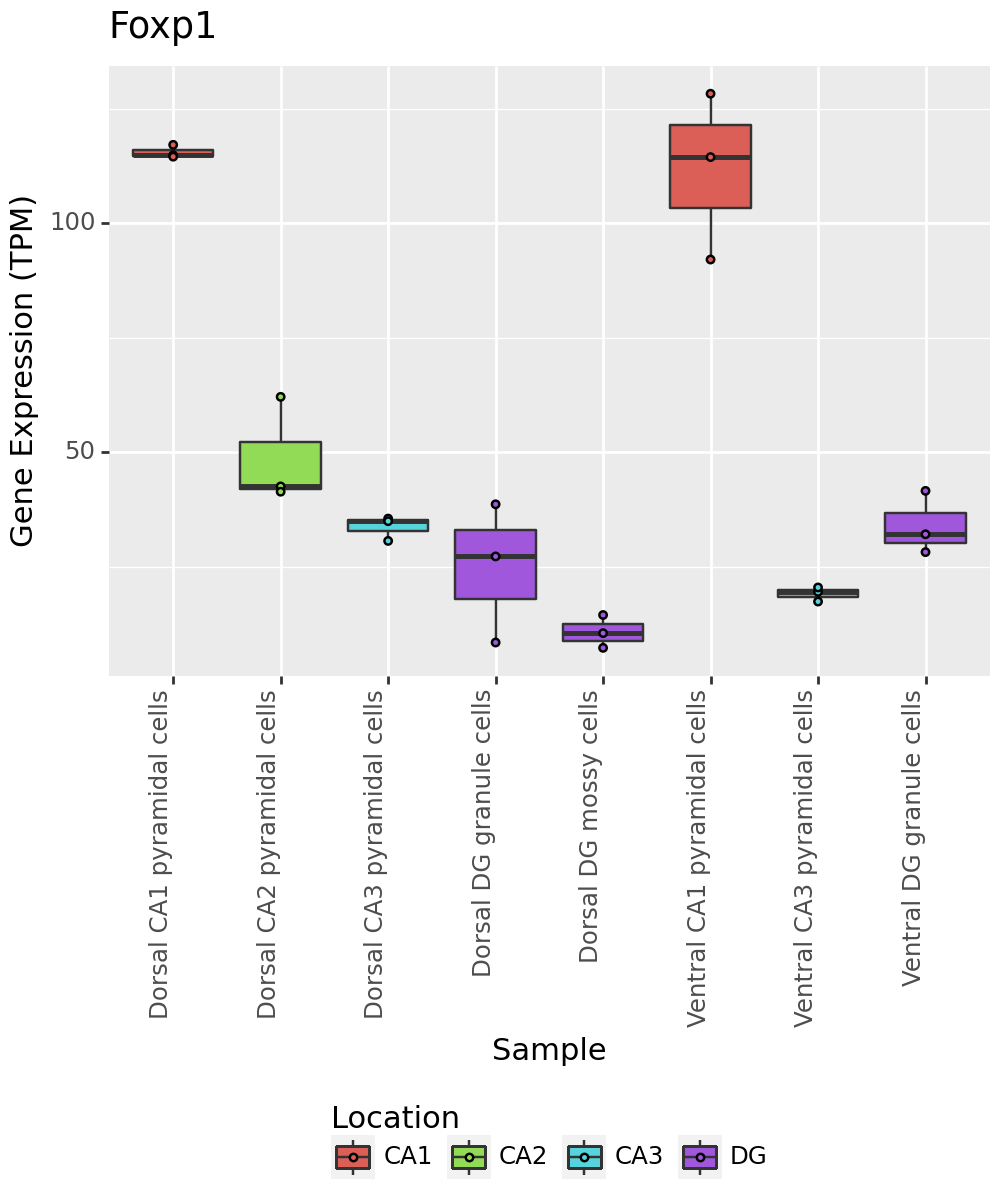

<Figure Size: (500 x 600)>

In [21]:
plot_gene(adata,"Foxp1")

